In [3]:
pip install openml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 1.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.2 MB/s eta 0:00:00
  Created wheel for openml: filename=openml-0.14.2-py3-none-any.whl size=158700 sha256=f5e2bf04a7ff6f5c48eba3c40a6f6221fc5f84578f2a836fbc04ab7a0fb58e16
  Stored in directory: /root/.cache/pip/wheels/2e/4e/af/5e721761d86375dbca82e63cc2470019e97815bc39f11451ea
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11717 sha256=8362b07db1195a022a8c1fbd41bc071b930edf9905840469e0c6ca01b7550845
  Stored in directory: /root/.cache/pip/wheels/5d/2a/9c/3895d9617f8f49a0883ba686326d598e78a1c2f54fe3cae86d
Successfully built openml liac-arff


In [4]:
import numpy as np
import openml
import pandas as pd
import pickle
import logging
import matplotlib.pyplot as plt

from scipy.stats import norm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler, LabelEncoder
from pathlib import Path



In [5]:
# Class representing the victim's model
class VictimModel:
    def __init__(self, dataset_id=37, output_dir='victim_model'):
        self.dataset_id = dataset_id
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(parents=True, exist_ok=True)
        self.model = RandomForestClassifier(n_estimators=100, random_state=42)
        self.X_train = None
        self.y_train = None
        self.scaler = StandardScaler()

    def load_and_train(self):
        # Load the dataset
        dataset = openml.datasets.get_dataset(self.dataset_id, download_data=True)
        X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute, dataset_format='dataframe')

        # Check for non-numeric columns in X
        non_numeric_columns = X.select_dtypes(include=['object', 'category']).columns
        print("Non-numeric columns:", non_numeric_columns)

        # Convert non-numeric columns to numeric using LabelEncoder
        label_encoders = {}
        for col in non_numeric_columns:
            label_encoders[col] = LabelEncoder()
            X[col] = label_encoders[col].fit_transform(X[col])

        # Standardize the features
        X = self.scaler.fit_transform(X)

        # Now split the data into training and test sets
        X_train, _, y_train, _ = train_test_split(X, y, test_size=0.4, random_state=42)
        self.X_train, self.y_train = X_train, y_train

        # Train the model
        self.model.fit(X_train, y_train)

        # Save the model to a file
        model_path = self.output_dir / 'victim_model.pkl'
        with open(model_path, 'wb') as f:
            pickle.dump(self.model, f)

        logging.info(f'Victim model trained and saved to {model_path}')
        return model_path


In [16]:
# Class representing the attacker's model
class AttackerModel:
    def __init__(self, victim_model_path, num_shadow_models=10, output_dir='attacker_model'):
        self.victim_model_path = victim_model_path
        self.num_shadow_models = num_shadow_models
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(parents=True, exist_ok=True)
        self.shadow_models = []
        self.models_with_x = []
        self.models_without_x = []

    def load_victim_model(self):
        with open(self.victim_model_path, 'rb') as f:
            self.victim_model = pickle.load(f)

    def train_shadow_models(self, X_train, y_train):
        for i in range(self.num_shadow_models):
            mask = np.random.rand(len(X_train)) < 0.5
            X_sampled, y_sampled = X_train[mask], y_train[mask]
            shadow_model = RandomForestClassifier(n_estimators=100, random_state=i)
            shadow_model.fit(X_sampled, y_sampled)
            self.shadow_models.append(shadow_model)
            self.models_with_x.append(mask)
            self.models_without_x.append(~mask)
            shadow_model_path = self.output_dir / f'shadow_model_{i}.pkl'
            with open(shadow_model_path, 'wb') as f:
                pickle.dump(shadow_model, f)
            logging.info(f"Shadow model {i} saved to {shadow_model_path}")

    def split_models_on_example(self, x_index):
        models_saw_x = []
        models_not_saw_x = []
        for i, model in enumerate(self.shadow_models):
            if self.models_with_x[i][x_index]:
                models_saw_x.append(model)
            else:
                models_not_saw_x.append(model)
        return models_saw_x, models_not_saw_x

    def calculate_loss(self, model, data_point, true_label):
            # Predict the probabilities for the data point
            proba = model.predict_proba([data_point])[0]

            # Find the index corresponding to the true label
            label_index = list(model.classes_).index(true_label)

            # Calculate the log loss
            loss = -np.log(proba[label_index] + 1e-15)  # Add a small constant to avoid log(0)
            return loss

    def perform_mia(self, x, true_label, models_saw_x, models_not_saw_x):
        losses_saw_x = [self.calculate_loss(model, x, true_label) for model in models_saw_x]
        losses_not_saw_x = [self.calculate_loss(model, x, true_label) for model in models_not_saw_x]
        mean_saw_x, std_saw_x = np.mean(losses_saw_x), np.std(losses_saw_x)
        mean_not_saw_x, std_not_saw_x = np.mean(losses_not_saw_x), np.std(losses_not_saw_x)
        loss_f_prime = self.calculate_loss(self.victim_model, x, true_label)
        likelihood_saw_x = norm.pdf(loss_f_prime, mean_saw_x, std_saw_x)
        likelihood_not_saw_x = norm.pdf(loss_f_prime, mean_not_saw_x, std_not_saw_x)
        likelihood_ratio = likelihood_saw_x / (likelihood_not_saw_x + 1e-15)
        is_member = likelihood_ratio > 1
        return is_member, loss_f_prime, mean_saw_x, std_saw_x, mean_not_saw_x, std_not_saw_x, likelihood_ratio


    def plot_distributions(self, x, true_label, models_saw_x, models_not_saw_x):
        losses_saw_x = [self.calculate_loss(model, x, true_label) for model in models_saw_x]
        losses_not_saw_x = [self.calculate_loss(model, x, true_label) for model in models_not_saw_x]
        mean_saw_x, std_saw_x = np.mean(losses_saw_x), np.std(losses_saw_x)
        mean_not_saw_x, std_not_saw_x = np.mean(losses_not_saw_x), np.std(losses_not_saw_x)
        loss_f_prime = self.calculate_loss(self.victim_model, x, true_label)

        # Generate x-axis values
        x_values = np.linspace(
            min(mean_saw_x - 3 * std_saw_x, mean_not_saw_x - 3 * std_not_saw_x),
            max(mean_saw_x + 3 * std_saw_x, mean_not_saw_x + 3 * std_not_saw_x),
            100
        )

        # Plotting the distributions
        plt.figure(figsize=(10, 6))
        plt.plot(x_values, norm.pdf(x_values, mean_saw_x, std_saw_x), label='Shadow Models that saw x', color='blue')
        plt.plot(x_values, norm.pdf(x_values, mean_not_saw_x, std_not_saw_x), label='Shadow Models that did not see x', color='green')
        plt.axvline(loss_f_prime, color='red', linestyle='--', label='Victim Model Loss f\'(x)')

        plt.title('Loss Distributions - Victim vs. Shadow Models')
        plt.xlabel('Loss')
        plt.ylabel('Probability Density')
        plt.legend()
        plt.show()

        # Set the output directory
        output_dir = Path('ru89vot2')
        output_dir.mkdir(parents=True, exist_ok=True)

        # Save the plot
        plot_path = output_dir / 'loss_distributions.png'
        plt.savefig(plot_path)
        plt.close()
        logging.info(f'Saved loss distribution plot to {plot_path}')


    def attack(self, X_train, y_train, x_index):
        self.load_victim_model()
        models_saw_x, models_not_saw_x = self.split_models_on_example(x_index)

        # Accessing the data by position directly
        is_member, loss_f_prime, mean_saw_x, std_saw_x, mean_not_saw_x, std_not_saw_x, likelihood_ratio = self.perform_mia(
            X_train[x_index], y_train[x_index], models_saw_x, models_not_saw_x)

        logging.info(f'Loss f\'(x): {loss_f_prime}')
        logging.info(f'Mean (saw x): {mean_saw_x}, Std (saw x): {std_saw_x}')
        logging.info(f'Mean (not saw x): {mean_not_saw_x}, Std (not saw x): {std_not_saw_x}')
        logging.info(f'Likelihood Ratio: {likelihood_ratio}')
        logging.info(f'Is x a member according to likelihood ratio? {"Yes" if is_member else "No"}')

        # Plot the distributions
        self.plot_distributions(X_train[x_index], y_train[x_index], models_saw_x, models_not_saw_x)

        return is_member, likelihood_ratio

<ipython-input-5-bfa45b463563>:14: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  dataset = openml.datasets.get_dataset(self.dataset_id, download_data=True)


Non-numeric columns: Index([], dtype='object')
X_train type: <class 'numpy.ndarray'>, shape: (230, 8)
y_train type: <class 'pandas.core.series.Series'>, shape: (230,)
X_train after conversion type: <class 'pandas.core.frame.DataFrame'>, shape: (230, 8)
y_train after conversion type: <class 'pandas.core.series.Series'>, shape: (230,)
X_train[0]: [-0.25095213 -0.77912776  0.45982725  1.15818217 -0.69289057  0.67361398
 -0.70633419  0.57511787]
y_train[0]: tested_negative


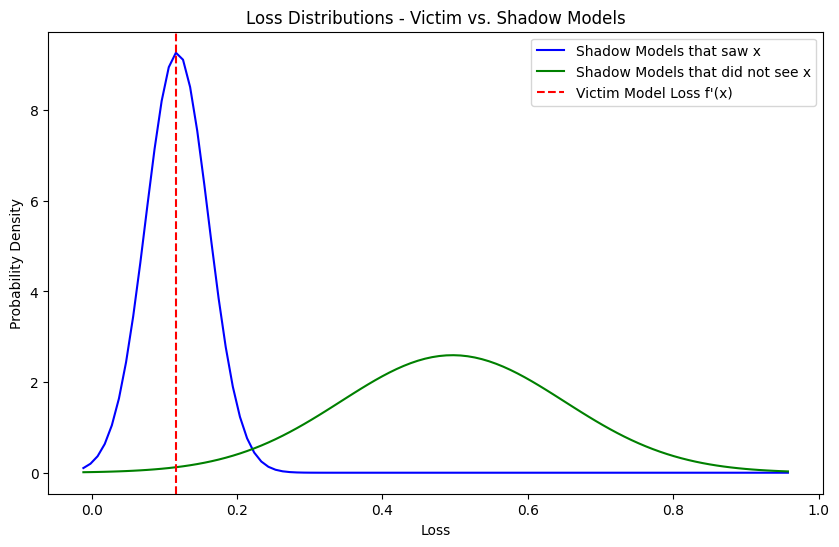

In [17]:
def main():
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

    # Victim trains their model
    victim = VictimModel()
    model_path = victim.load_and_train()

    # Simulate attack
    attacker = AttackerModel(victim_model_path=model_path)

    # Assuming the attacker has some knowledge of the domain but not the exact dataset
    X_train, _, y_train, _ = train_test_split(victim.X_train, victim.y_train, test_size=0.5, random_state=42)

    # Debug: Check the type and content of X_train and y_train
    print(f"X_train type: {type(X_train)}, shape: {X_train.shape}")
    print(f"y_train type: {type(y_train)}, shape: {y_train.shape}")

    # Convert to DataFrame/Series and reset indices
    X_train = pd.DataFrame(X_train).reset_index(drop=True)
    y_train = pd.Series(y_train).reset_index(drop=True)

    # Debug: Check the type and content after conversion
    print(f"X_train after conversion type: {type(X_train)}, shape: {X_train.shape}")
    print(f"y_train after conversion type: {type(y_train)}, shape: {y_train.shape}")

    # Ensure the values are passed correctly to the shadow models
    attacker.train_shadow_models(X_train.values, y_train.values)

    # Perform attack on the first example using iloc to access by position
    x_index = 0

    # Debug: Check the values being passed to the attack function
    print(f"X_train[0]: {X_train.iloc[x_index].values}")
    print(f"y_train[0]: {y_train.iloc[x_index]}")

    attacker.attack(X_train.values, y_train.values, x_index)

if __name__ == "__main__":
    main()
